In [1]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

import pickle

import numpy as np

import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

import joblib

from libs.container import Container
from libs.display import d
from libs.experiment import KFoldExperiment, WithAnotherExperiment, roc

In [2]:
cpu = joblib.cpu_count()

In [3]:
sample = pd.read_pickle("data/scaled/sample.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])

no_features = ["id", "vs_catalog", "vs_type", "ra_k", "dec_k", "tile", "cls"] 
X_columns = [c for c in sample.columns if c not in no_features]

grouped = sample.groupby("tile")
data = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})
data = Container(data=pd.concat([data.b278, data.b261]))

cls = {name: idx for idx, name in enumerate(data.data.tile.unique())}
data.data["cls"] = data.data.tile.apply(cls.get)

del grouped, sample

cls

{'b261': 1, 'b278': 0}

In [4]:
cls = {v: v for v in cls.values()}

In [5]:
data.data.columns

Index([u'Amplitude', u'AmplitudeH', u'AmplitudeJ', u'AmplitudeJH',
       u'AmplitudeJK', u'Autocor_length', u'Beyond1Std', u'CAR_mean',
       u'CAR_sigma', u'CAR_tau', u'Con', u'Eta_e', u'FluxPercentileRatioMid20',
       u'FluxPercentileRatioMid35', u'FluxPercentileRatioMid50',
       u'FluxPercentileRatioMid65', u'FluxPercentileRatioMid80',
       u'Freq1_harmonics_amplitude_0', u'Freq1_harmonics_amplitude_1',
       u'Freq1_harmonics_amplitude_2', u'Freq1_harmonics_amplitude_3',
       u'Freq1_harmonics_rel_phase_0', u'Freq1_harmonics_rel_phase_1',
       u'Freq1_harmonics_rel_phase_2', u'Freq1_harmonics_rel_phase_3',
       u'LinearTrend', u'MaxSlope', u'Mean', u'Meanvariance', u'MedianAbsDev',
       u'MedianBRP', u'PairSlopeTrend', u'PercentAmplitude',
       u'PercentDifferenceFluxPercentile', u'PeriodLS', u'Period_fit',
       u'Psi_CS', u'Psi_eta', u'Q31', u'Rcs', u'Skew', u'SmallKurtosis',
       u'Std', u'c89_c3', u'c89_hk_color', u'c89_jh_color', u'c89_jk_color',
       u

In [6]:
RF_PARAMS = {
    'max_features': None, 'min_samples_split': 10, 'n_jobs': cpu, 
    'criterion': 'entropy', 'n_estimators': 500}

SVM_PARAMS = {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001, 'probability': True}

In [7]:
%%time
rf = KFoldExperiment(
    clf=RandomForestClassifier(**RF_PARAMS), clsnum=cls, 
    data=data, pcls=1, ncls=0, X_columns=X_columns, y_column="cls")
rf = rf("data", nfolds=10)

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       994
         1.0       0.89      0.84      0.86       998

   micro avg       0.87      0.87      0.87      1992
   macro avg       0.87      0.87      0.87      1992
weighted avg       0.87      0.87      0.87      1992

--------------------------------------------------------------------------------
CPU times: user 16min 40s, sys: 6.71 s, total: 16min 47s
Wall time: 50.7 s


In [8]:
%%time
svm = KFoldExperiment(
    clf=SVC(**SVM_PARAMS), clsnum=cls, 
    data=data, pcls=1, ncls=0, X_columns=X_columns, y_column="cls")
svm = svm("data", nfolds=10)

              precision    recall  f1-score   support

         0.0       0.76      0.72      0.74       994
         1.0       0.74      0.77      0.75       998

   micro avg       0.75      0.75      0.75      1992
   macro avg       0.75      0.75      0.75      1992
weighted avg       0.75      0.75      0.75      1992

--------------------------------------------------------------------------------
CPU times: user 1min 13s, sys: 5 ms, total: 1min 13s
Wall time: 1min 13s


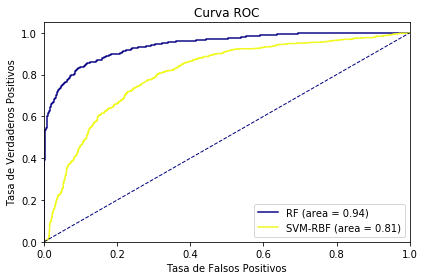

In [29]:
roc({"SVM-RBF": svm, "RF": rf});
plt.savefig("plots/model_select.pdf")

In [27]:
print(
    pd.DataFrame([
        ["SVM-RBD", svm.prec_rec[0], svm.prec_rec[1], svm.roc_auc],
        ["RF", rf.prec_rec[0], rf.prec_rec[1], rf.roc_auc]],
        columns="Modelo Precision Recall AUC".split()
    ).to_latex(index=False, float_format="%.4f"))

\begin{tabular}{lrrr}
\toprule
  Modelo &  Precision &  Recall &    AUC \\
\midrule
 SVM-RBD &     0.7363 &  0.7665 & 0.8068 \\
      RF &     0.8876 &  0.8387 & 0.9412 \\
\bottomrule
\end{tabular}



In [31]:
np.save("data/results/model_selection.pkl", [rf, svm])